In [1]:
# Setup
import re
import os
import json
import numpy as np
import pandas as pd
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter



from utils import get_file_names, LogParser

%load_ext autoreload
%autoreload 2

parser = LogParser()
benchmarks = {}
linestyles = [":", "--", "-."]
markers = ["o", "v", "s"]

# Hyperparameter search

In [2]:
def plot_acc_cost(dfs_labels, variable, task, folder="", ablation="", ylimacc=None, ylimcost=None):
    # Define a formatter function
    def custom_formatter(x, pos):
        return f'{x:.2f}'

    # Apply the formatter to the y-axis
    

    if len(dfs_labels) == 1:
        eps = [0]
    elif len(dfs_labels) == 2:
        eps = [-0.1, 0.1]
    else:
        raise NotImplementedError("Only 1 or 2 dfs are supported")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    for i, (df, label) in enumerate(dfs_labels):
        df = df.sort_values(variable, ascending=True)
        x = df[variable].to_list()
        acc = df["Accuracy"].to_list()
        cost = df["Cost"].to_list()
        err_low = df["error_low"].to_list()
        err_high = df["error_high"].to_list()

        yerr = [err_low, err_high]
        ticks = np.arange(len(x))/10
        padding = 0.1
        ax1.set_xlim(min(ticks) - padding, max(ticks) + padding)
        ax2.set_xlim(min(ticks) - padding, max(ticks) + padding)
        
        ax1.errorbar(ticks+eps[i]/10, acc, yerr=yerr, capsize=5, capthick=1, fmt=markers[i], markersize=5, linestyle=None, label=label)
        ax1.set_ylabel('Accuracy')
        if ylimacc:
            ax1.set_ylim(ylimacc)
        ax1.legend()
        if i == 0:
            ax1.set_xticks(ticks)
            ax1.set_xticklabels(x)
            ax1.yaxis.set_major_formatter(FuncFormatter(custom_formatter))

        #ax2.bar(ticks, cost, color="r", alpha=0.4, label="FoA")
        ax2.errorbar(ticks+eps[i]/10, cost, yerr=0, capsize=5, capthick=1, fmt=markers[i], markersize=5, linestyle=None, label=label)
        ax2.set_ylabel('Cost ($)')
        if ylimcost:
            ax2.set_ylim(ylimcost)
        ax2.legend()
        if i == 0:
            ax2.set_xticks(ticks)
            ax2.set_xticklabels(x)
            if folder != "pics":
                ax2.yaxis.set_major_formatter(FuncFormatter(custom_formatter))
    
    task2name = {"gameof24": "Game of 24", "crosswords": "Crosswords", "webshop": "WebShop", "all" : "All tasks"}
    ablation2name = {"selection": "Selection phase ablation", "batching": "Batching ablation", "backtracking": "Backtracking ablation"}
    
    #plt.tight_layout()

    if folder == "ablations":
        plt.suptitle(f"{task2name[task]} - {ablation2name[ablation]}")
        plt.savefig(f"pics/{folder}/{ablation}/{task}.png", dpi=300)
    elif folder == "hyperparameter_search":
        plt.suptitle(f"{task2name[task]} - {variable} tuning")
        plt.savefig(f"pics/{folder}/{task}/{variable}.png", dpi=300)
    elif folder == "pics":
        plt.suptitle("FoA performance accross tasks")
        plt.savefig(f"pics/summary.png", dpi=300)
    plt.show()

## Game of 24

In [3]:
#-----------------#
#---ToT Results---#
#-----------------#  
    
folder = "arxiv/benchmarks/gameof24/ChatGPT/ToT/"
files = [folder + f for f in get_file_names(folder)]
rewards = []
costs = []

for file in files:
    rewards_, cost_ = parser.get_data(file, task="gameof24", method="tot")
    rewards.extend(rewards_)
    costs.append(cost_)

rewards = np.array(rewards)
costs = np.array(costs)

tot = {}    
tot["Accuracy"] = bootstrap(rewards.reshape((1,-1)), np.mean).bootstrap_distribution.mean()
tot["CI_Low"], tot["CI_High"] = bootstrap(rewards.reshape((1,-1)), np.mean).confidence_interval
tot["Cost"] = bootstrap(costs.reshape((1,-1)), np.mean).bootstrap_distribution.mean()
tot["label"] = "ToT"

benchmarks["gameof24"] = {"tot":tot}


#-----------------#
#---FoA Results---#
#-----------------#

folder = "logs_old/test/gameof24/"
folder = "logs_old/gridsearch_final2/gameof24/"
files = [folder + f for f in get_file_names(folder)]

data = [parser.get_data(file, task="gameof24", method="foa") for file in files]

/dlabdata1/potamiti/miniconda3/envs/FoA/lib/python3.12/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/dlabdata1/potamiti/FoA/utils.py:734: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  bootstrapped = bootstrap(array.reshape((1,-1)), np.mean)


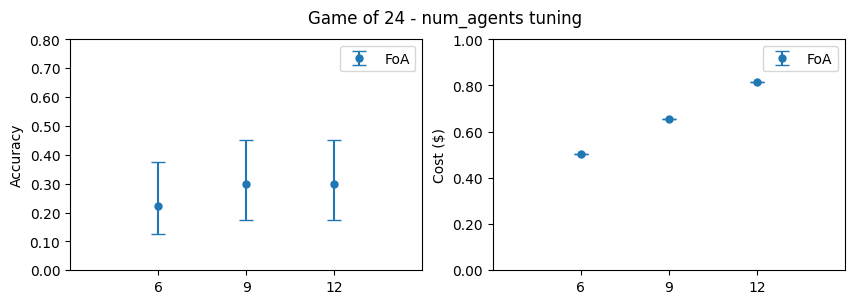

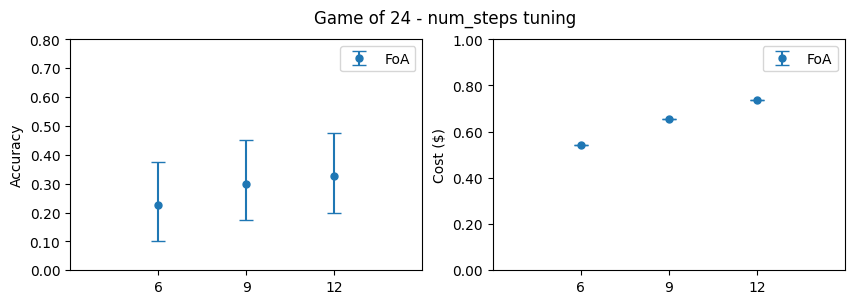

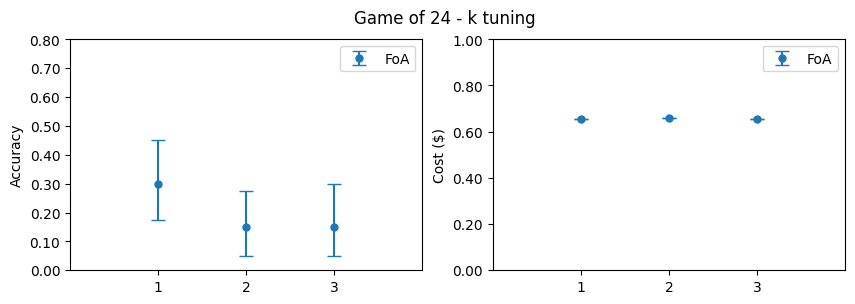

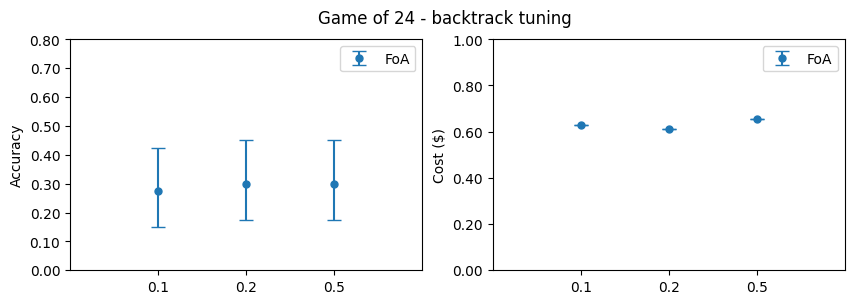

In [4]:
df = pd.DataFrame(data)
task="gameof24"

best_config = {"num_agents":9, "num_steps":9, "k":1, "backtrack":0.5}
ylimacc = [0.0, 0.8]
ylimcost = [0.0, 1.0]

# num_agents
variable = "num_agents"
temp = df[(df["num_steps"] == best_config["num_steps"]) & (df["k"] == best_config["k"]) & (df["backtrack"] == best_config["backtrack"])]
plot_acc_cost([(temp, "FoA")], variable, task, ylimacc=ylimacc, ylimcost=ylimcost, folder="hyperparameter_search")

# num_steps
variable="num_steps"
temp = df[(df["num_agents"] == best_config["num_agents"]) & (df["k"] == best_config["k"]) & (df["backtrack"] == best_config["backtrack"])]
plot_acc_cost([(temp, "FoA")], variable, task, ylimacc=ylimacc, ylimcost=ylimcost, folder="hyperparameter_search")
# k
variable = "k"
temp = df[(df["num_agents"] == best_config["num_agents"]) & (df["num_steps"] == best_config["num_steps"]) & (df["backtrack"] == best_config["backtrack"])]
plot_acc_cost([(temp, "FoA")], variable, task, ylimacc=ylimacc, ylimcost=ylimcost, folder="hyperparameter_search")
# backtrack
variable = "backtrack"
temp = df[(df["num_agents"] == best_config["num_agents"]) & (df["num_steps"] == best_config["num_steps"]) & (df["k"] == best_config["k"])]
plot_acc_cost([(temp, "FoA")], variable, task, ylimacc=ylimacc, ylimcost=ylimcost, folder="hyperparameter_search")

## Crosswords

In [5]:
#-----------------#
#---ToT Results---#
#-----------------#
    
folder = "arxiv/benchmarks/crosswords/ChatGPT/ToT/"
files = [folder + f for f in get_file_names(folder)]
rewards = []
costs = []

for file in files:
    rewards_, cost_ = parser.get_data(file, task="crosswords", method="tot")
    rewards.append(rewards_)
    costs.append(cost_)

rewards = np.array([r["r_letter"] for r in rewards]).flatten()
costs = np.array(costs)

tot = {}    
tot["Accuracy"] = bootstrap(rewards.reshape((1,-1)), np.mean).bootstrap_distribution.mean()
tot["CI_Low"], tot["CI_High"] = bootstrap(rewards.reshape((1,-1)), np.mean).confidence_interval
tot["Cost"] = bootstrap(costs.reshape((1,-1)), np.mean).bootstrap_distribution.mean()
tot["label"] = "ToT"

benchmarks["crosswords"] = {"tot":tot}


#-----------------#
#---FoA Results---#
#-----------------#

folder = "logs_old/gridsearch1/crosswords/"
files = [folder + f for f in get_file_names(folder)]

data = [parser.get_data(file, task="crosswords", method="foa") for file in files]

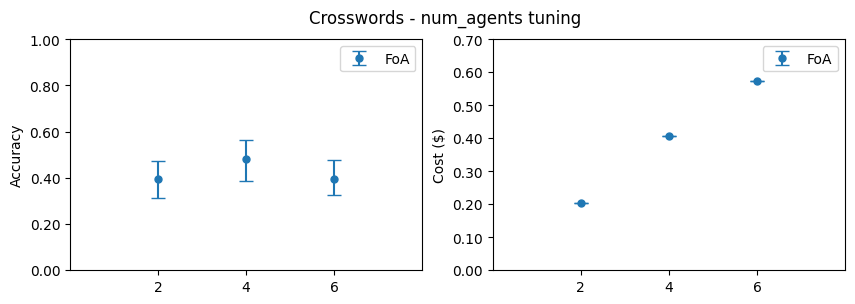

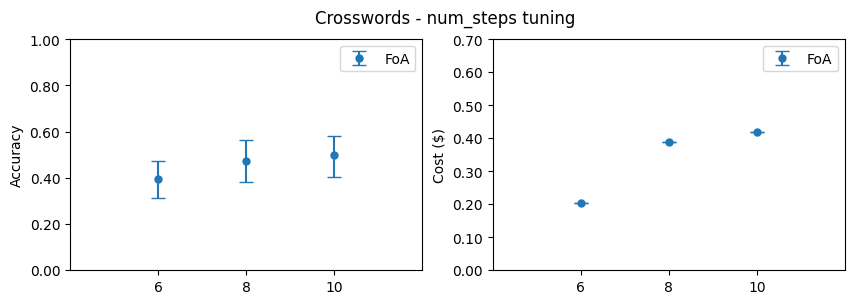

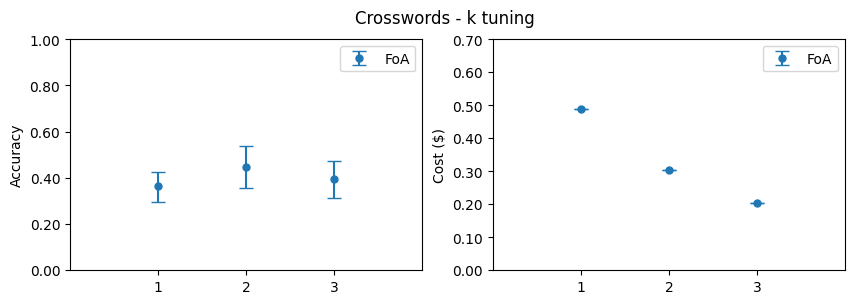

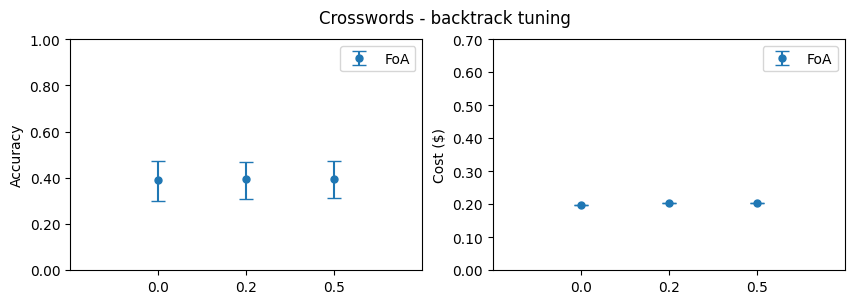

In [6]:
df = pd.DataFrame(data)
task = "crosswords"

best_config = {"num_agents":2, "num_steps":6, "k":3, "backtrack":0.5}

ylimacc = (0.0, 1.0)
ylimcost = (0.0, 0.7)

# num_agents
variable = "num_agents"
temp = df[(df["num_steps"] == best_config["num_steps"]) & (df["k"] == best_config["k"]) & (df["backtrack"] == best_config["backtrack"])]
plot_acc_cost([(temp, "FoA")], variable, task, ylimacc=ylimacc, ylimcost=ylimcost, folder="hyperparameter_search")

# num_steps
variable="num_steps"
temp = df[(df["num_agents"] == best_config["num_agents"]) & (df["k"] == best_config["k"]) & (df["backtrack"] == best_config["backtrack"])]
plot_acc_cost([(temp, "FoA")], variable, task, ylimacc=ylimacc, ylimcost=ylimcost, folder="hyperparameter_search")

# k
variable = "k"
temp = df[(df["num_agents"] == best_config["num_agents"]) & (df["num_steps"] == best_config["num_steps"]) & (df["backtrack"] == best_config["backtrack"])]
plot_acc_cost([(temp, "FoA")], variable, task, ylimacc=ylimacc, ylimcost=ylimcost, folder="hyperparameter_search")

# backtrack
variable = "backtrack"
temp = df[(df["num_agents"] == best_config["num_agents"]) & (df["num_steps"] == best_config["num_steps"]) & (df["k"] == best_config["k"])]
plot_acc_cost([(temp, "FoA")], variable, task, ylimacc=ylimacc, ylimcost=ylimcost, folder="hyperparameter_search")

## WebShop

In [29]:
#----------------#
#---Benchmarks---#
#----------------#
folder = "arxiv/benchmarks/webshop/react/"
react_30_data = parser.get_data(folder, task="webshop", method="react", num_agents=30)
rewards = np.array(react_30_data["rewards"])
react_30 = {}    
react_30["Accuracy"] = bootstrap(rewards.reshape((1,-1)), np.mean).bootstrap_distribution.mean()
react_30["CI_Low"], react_30["CI_High"] = bootstrap(rewards.reshape((1,-1)), np.mean).confidence_interval
react_30["Cost"] = react_30_data["Cost"]
react_30["label"] = "React (best of 30)"

react_1_data = parser.get_data(folder, task="webshop", method="react", num_agents=1)
rewards = np.array(react_1_data["rewards"])
react_1 = {}    
react_1["Accuracy"] = bootstrap(rewards.reshape((1,-1)), np.mean).bootstrap_distribution.mean()
react_1["CI_Low"], react_1["CI_High"] = bootstrap(rewards.reshape((1,-1)), np.mean).confidence_interval
react_1["Cost"] = react_1_data["Cost"]
react_1["label"] = "React (best of 30)"

benchmarks["webshop"] = {"react_30":react_30, "react_1":react_1}


#-----------------#
#---FoA Results---#
#-----------------#

folder = "logs_old/grid_mixed/"
files = [folder + f for f in get_file_names(folder)]

data = [parser.get_data(file, task="webshop", method="foa") for file in files]

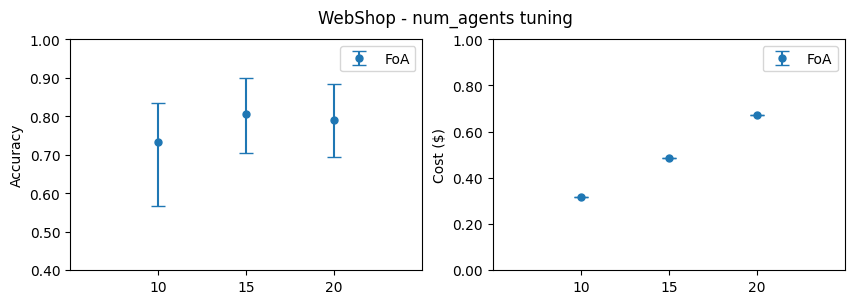

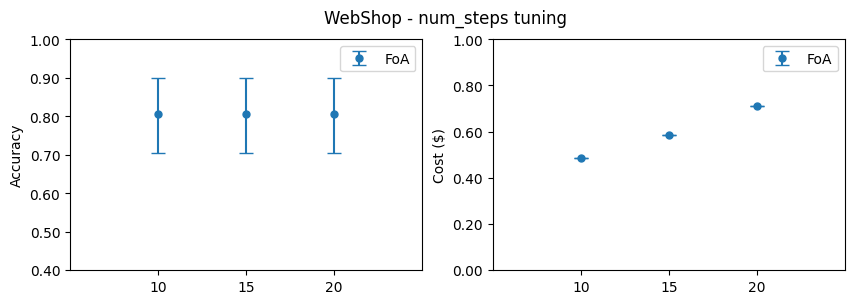

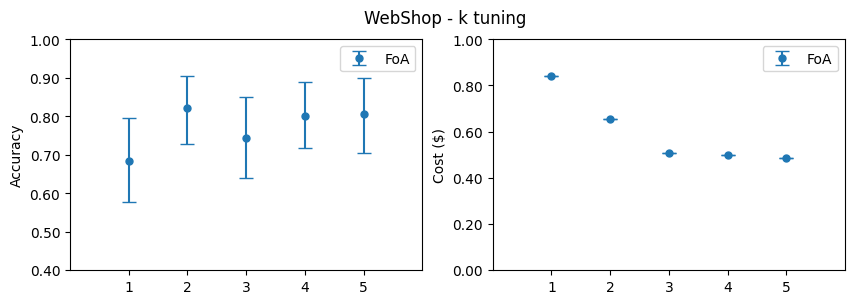

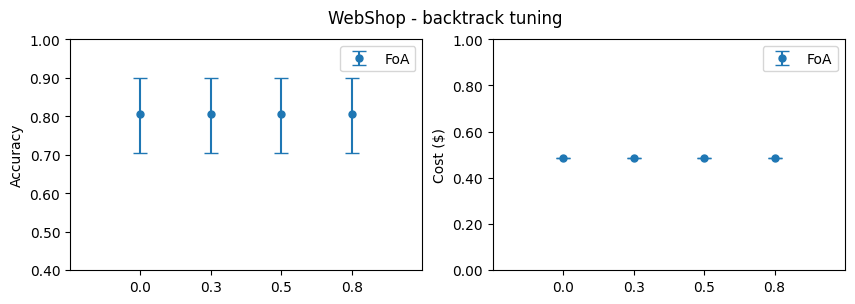

In [30]:
df = pd.DataFrame(data)
task = "webshop"

best_config = {"num_agents":15, "num_steps":10, "k":5, "backtrack":0.5}
ylimacc = (0.4, 1)
ylimcost = (0, 1)

# num_agents
variable = "num_agents"
temp = df[(df["num_steps"] == best_config["num_steps"]) & (df["k"] == best_config["k"]) & (df["backtrack"] == best_config["backtrack"])]
plot_acc_cost([(temp, "FoA")], variable, task, ylimacc=ylimacc, ylimcost=ylimcost, folder="hyperparameter_search")

# num_steps
variable="num_steps"
temp = df[(df["num_agents"] == best_config["num_agents"]) & (df["k"] == best_config["k"]) & (df["backtrack"] == best_config["backtrack"])]
plot_acc_cost([(temp, "FoA")], variable, task, ylimacc=ylimacc, ylimcost=ylimcost, folder="hyperparameter_search")

# k
variable = "k"
temp = df[(df["num_agents"] == best_config["num_agents"]) & (df["num_steps"] == best_config["num_steps"]) & (df["backtrack"] == best_config["backtrack"])]
plot_acc_cost([(temp, "FoA")], variable, task, ylimacc=ylimacc, ylimcost=ylimcost, folder="hyperparameter_search")

# backtrack
variable = "backtrack"
temp = df[(df["num_agents"] == best_config["num_agents"]) & (df["num_steps"] == best_config["num_steps"]) & (df["k"] == best_config["k"])]
plot_acc_cost([(temp, "FoA")], variable, task, ylimacc=ylimacc, ylimcost=ylimcost, folder="hyperparameter_search")

# Ablation studies

## Selection



FoA VS Best of k (FoA without Selection) at varying k

/dlabdata1/potamiti/miniconda3/envs/FoA/lib/python3.12/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/dlabdata1/potamiti/FoA/utils.py:734: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  bootstrapped = bootstrap(array.reshape((1,-1)), np.mean)


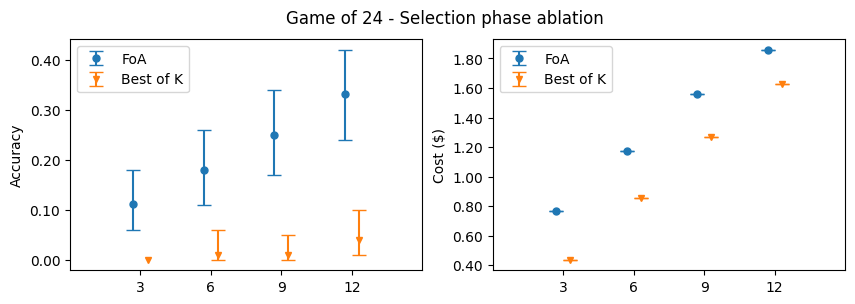

In [9]:
#---Game of 24---#
folder = "logs_recent/ablations/selection/gameof24/"
files = [folder + f for f in get_file_names(folder)]

data = [parser.get_data(file, task="gameof24", method="foa") for file in files]

df = pd.DataFrame(data)
df.sort_values("num_agents", ascending=True, inplace=True)

temp_foa = df[df.k==1]

temp_bok = df[df.k==0]

plot_acc_cost(dfs_labels=[(temp_foa, "FoA"), (temp_bok, "Best of K")], variable="num_agents", task="gameof24", folder="ablations", ablation="selection")

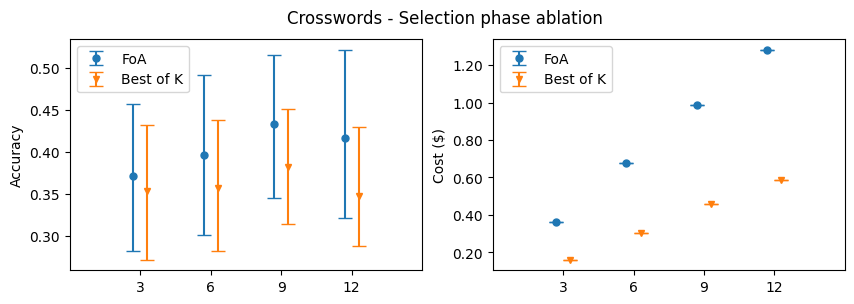

In [10]:
#---Crosswords---#
folder = "logs_recent/ablations/selection/crosswords/"
files = [folder + f for f in get_file_names(folder)]

data = [parser.get_data(file, task="crosswords", method="foa") for file in files]

df = pd.DataFrame(data)
df.sort_values("num_agents", ascending=True, inplace=True)

temp_foa = df[df.k==3]
temp_bok = df[df.k==0]

plot_acc_cost(dfs_labels=[(temp_foa, "FoA"), (temp_bok, "Best of K")], variable="num_agents", task="crosswords", folder="ablations", ablation="selection")

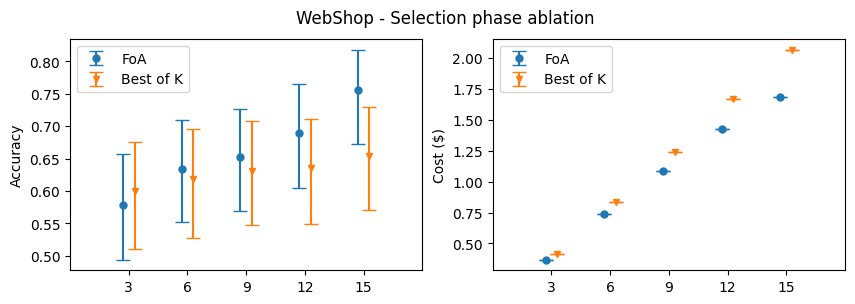

In [11]:
#---WebShop---#

# FoA data
foa_folder = "logs_recent/ablations/selection/webshop/foa/"
files = [foa_folder + f for f in get_file_names(foa_folder)]
data = [parser.get_data(file, task="webshop", method="foa") for file in files]

# Best of k data
bok_folder = "logs_recent/ablations/selection/webshop/bok/"
num_agents = [d["num_agents"] for d in data]
data.extend([parser.get_data(bok_folder, task="webshop", method="react", num_agents=n) for n in num_agents])

df = pd.DataFrame(data)
df.sort_values("num_agents", ascending=True, inplace=True)

temp_foa = df[df.k==4]
temp_bok = df[df.k==0]

plot_acc_cost(dfs_labels=[(temp_foa, "FoA"), (temp_bok, "Best of K")], variable="num_agents", task="webshop", folder="ablations", ablation="selection")

## Batching

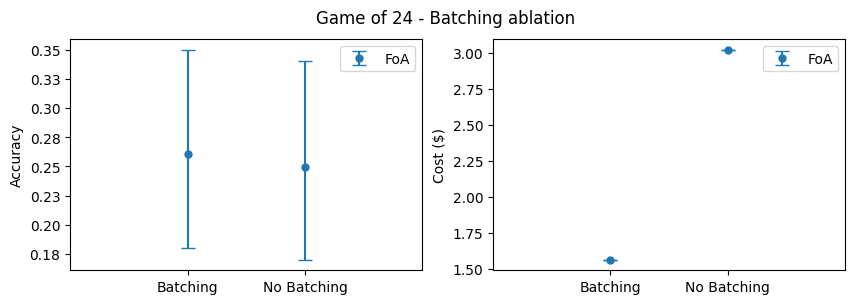

In [12]:
folder = "logs_recent/ablations/batching/gameof24/"
files = [folder + f for f in get_file_names(folder)]

data = [parser.get_data(file, task="gameof24", method="foa") for file in files]

df = pd.DataFrame(data)
df.sort_values(by=["Batching"], inplace=True)
df["Batching"] = df["Batching"].apply(lambda x: "Batching" if x else "No Batching")

plot_acc_cost(dfs_labels=[(df, "FoA")], variable="Batching", task="gameof24", folder="ablations", ablation="batching")

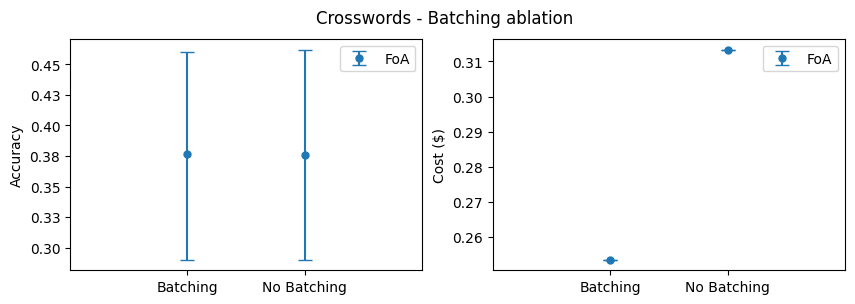

In [13]:
folder = "logs_recent/ablations/batching/crosswords/"
files = [folder + f for f in get_file_names(folder)]

data = [parser.get_data(file, task="crosswords", method="foa") for file in files]

df = pd.DataFrame(data)
df.sort_values(by=["Batching"], inplace=True)
df["Batching"] = df["Batching"].apply(lambda x: "Batching" if x else "No Batching")

plot_acc_cost(dfs_labels=[(df, "FoA")], variable="Batching", task="crosswords", folder="ablations", ablation="batching")

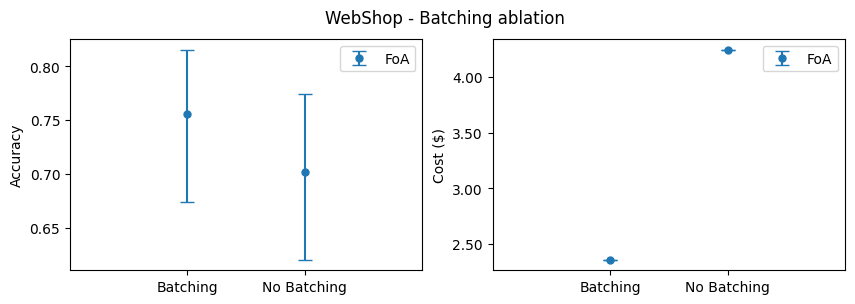

In [14]:
folder = "logs_recent/ablations/batching/webshop/"
files = [folder + f for f in get_file_names(folder)]

data = [parser.get_data(file, task="webshop", method="foa") for file in files]

df = pd.DataFrame(data)
df.sort_values(by=["Batching"], inplace=True)
df["Batching"] = df["Batching"].apply(lambda x: "Batching" if x else "No Batching")

plot_acc_cost(dfs_labels=[(df, "FoA")], variable="Batching", task="webshop", folder="ablations", ablation="batching")

## Backtracking

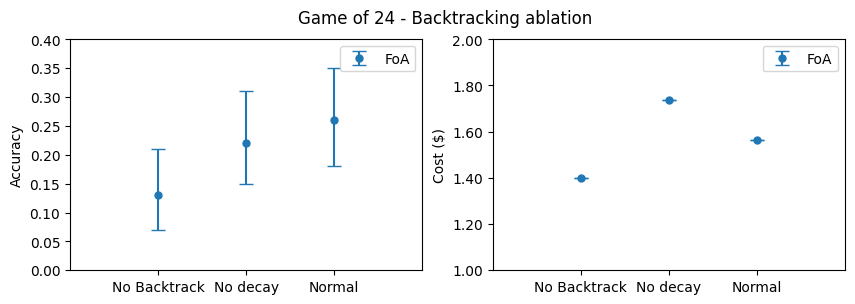

In [15]:
folder = "logs_recent/ablations/backtracking/gameof24/"
files = [folder + f for f in get_file_names(folder)]

data = [parser.get_data(file, task="gameof24", method="foa") for file in files]

df = pd.DataFrame(data)
dictionary = {0.0:"No Backtrack",1.0:"No decay"}
df["Backtracking"] = df["backtrack"].apply(lambda x: dictionary.get(x, "Normal"))
df.sort_values(by=["Backtracking"], inplace=True)

plot_acc_cost(dfs_labels=[(df, "FoA")], variable="Backtracking", task="gameof24", ylimacc=(0.0, 0.4), ylimcost=(1.0, 2.0), folder="ablations", ablation="backtracking")

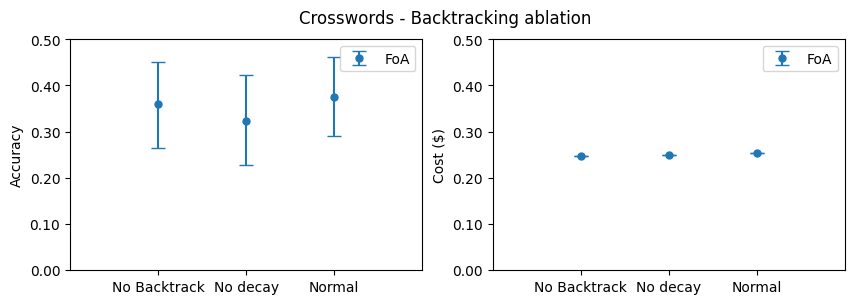

In [16]:
folder = "logs_recent/ablations/backtracking/crosswords/"
files = [folder + f for f in get_file_names(folder)]

data = [parser.get_data(file, task="crosswords", method="foa") for file in files]

df = pd.DataFrame(data)
dictionary = {0.0:"No Backtrack",1.0:"No decay"}
df["Backtracking"] = df["backtrack"].apply(lambda x: dictionary.get(x, "Normal"))
df.sort_values(by=["Backtracking"], inplace=True)

plot_acc_cost(dfs_labels=[(df, "FoA")], variable="Backtracking", task="crosswords", ylimacc=(0.0, 0.5), ylimcost=(0.0, 0.5), folder="ablations", ablation="backtracking")

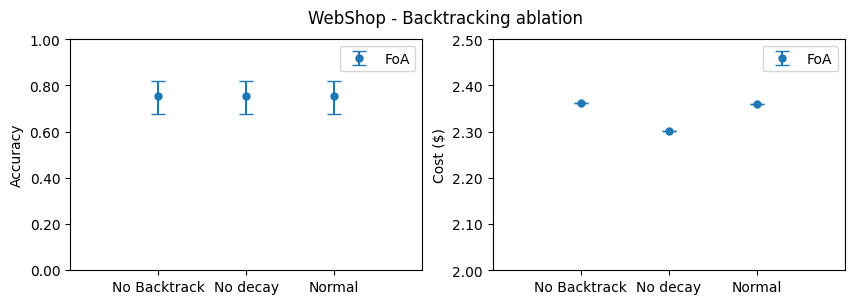

In [17]:
folder = "logs_recent/ablations/backtracking/webshop/"
files = [folder + f for f in get_file_names(folder)]

data = [parser.get_data(file, task="webshop", method="foa") for file in files]

df = pd.DataFrame(data)
dictionary = {0.0:"No Backtrack",1.0:"No decay"}
df["Backtracking"] = df["backtrack"].apply(lambda x: dictionary.get(x, "Normal"))
df.sort_values(by=["Backtracking"], inplace=True)

x = df.Backtracking.to_list()
y1 = df.Accuracy.to_list()
y2 = df.Cost.to_list()

plot_acc_cost(dfs_labels=[(df, "FoA")], variable="Backtracking", task="webshop", ylimacc=(0.0, 1.0), ylimcost=(2.0, 2.5), folder="ablations", ablation="backtracking")

## Resampling

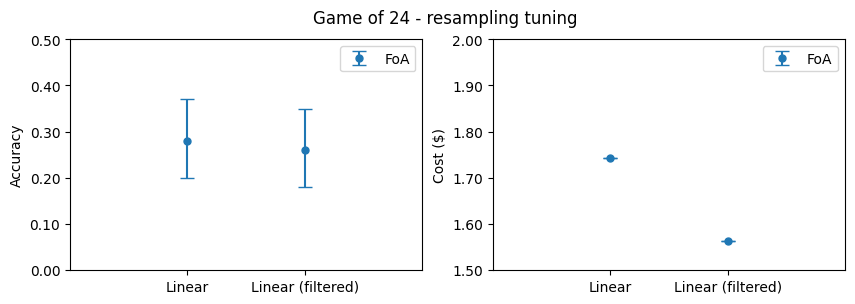

In [18]:
folder = "logs_recent/hyperparameter_search/resampling/gameof24/"
files = [folder + f for f in get_file_names(folder)]

data = [parser.get_data(file, task="gameof24", method="foa") for file in files]

df = pd.DataFrame(data)
dictionary = {"linear":"Linear", "linear_filtered": "Linear (filtered)"}
df["resampling"] = df["resampling"].apply(lambda x: dictionary.get(x, "?"))
df.sort_values(by=["resampling"], inplace=True)


plot_acc_cost(dfs_labels=[(df, "FoA")], variable="resampling", task="gameof24", ylimacc=(0.0, 0.5), ylimcost=(1.5, 2.0), folder="hyperparameter_search")

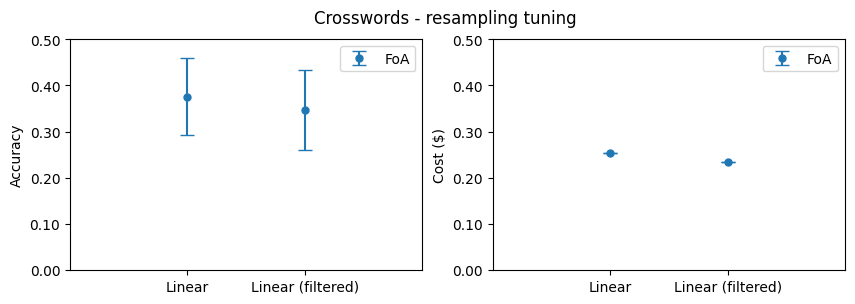

In [19]:
folder = "logs_recent/hyperparameter_search/resampling/crosswords/"
files = [folder + f for f in get_file_names(folder)]

data = [parser.get_data(file, task="crosswords", method="foa") for file in files]

df = pd.DataFrame(data)
dictionary = {"linear":"Linear", "linear_filtered": "Linear (filtered)"}
df["resampling"] = df["resampling"].apply(lambda x: dictionary.get(x, "?"))
df.sort_values(by=["resampling"], inplace=True)

plot_acc_cost(dfs_labels=[(df, "FoA")], variable="resampling", task="crosswords", ylimacc=(0.0, 0.5), ylimcost=(0.0, 0.5), folder="hyperparameter_search")

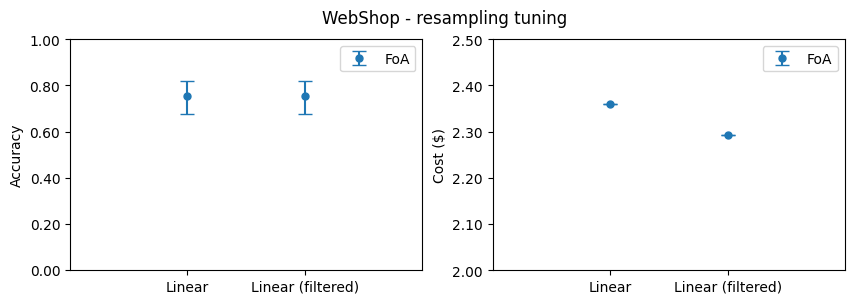

In [20]:
folder = "logs_recent/hyperparameter_search/resampling/webshop/"
files = [folder + f for f in get_file_names(folder)]

data = [parser.get_data(file, task="webshop", method="foa") for file in files]

df = pd.DataFrame(data)
dictionary = {"linear":"Linear", "linear_filtered": "Linear (filtered)"}
df["resampling"] = df["resampling"].apply(lambda x: dictionary.get(x, "?"))
df.sort_values(by=["resampling"], inplace=True)

plot_acc_cost(dfs_labels=[(df, "FoA")], variable="resampling", task="webshop", ylimacc=(0.0, 1.0), ylimcost=(2.0, 2.5), folder="hyperparameter_search")

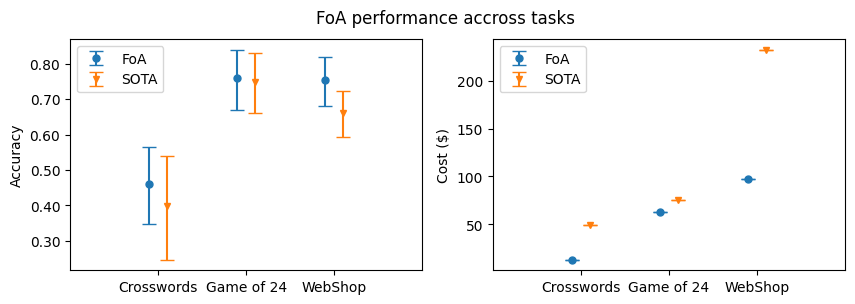

In [21]:
data_foa = [
    {"task": "Game of 24", "method": "foa", "Accuracy": 0.76, "ci_low": 0.67, "ci_high": 0.84, "Cost": 62.93, "error_low": 0.76-0.67, "error_high": 0.84-0.76},
    {"task": "Crosswords", "method": "foa", "Accuracy": 0.46, "ci_low": 0.348, "ci_high": 0.566, "Cost": 12.938, "error_low": 0.46-0.348, "error_high": 0.566-0.46},
    {"task": "WebShop", "method": "foa", "Accuracy": 0.7559, "ci_low": 0.68, "ci_high": 0.82, "Cost": 97, "error_low": 0.7559-0.68, "error_high": 0.82-0.7559},
]

data_sota = [
    {"task": "Game of 24", "method": "SOTA", "Accuracy": 0.75, "ci_low": 0.66, "ci_high": 0.83, "Cost": 75.02, "error_low": 0.75-0.66, "error_high": 0.83-0.75},
    {"task": "Crosswords", "method": "SOTA", "Accuracy": 0.397, "ci_low": 0.246, "ci_high": 0.54, "Cost": 48.988, "error_low": 0.397-0.246, "error_high": 0.54-0.397},
    {"task": "WebShop", "method": "SOTA", "Accuracy": 0.6607, "ci_low": 0.5939, "ci_high": 0.7246, "Cost": 232.28, "error_low": 0.6607-0.5939, "error_high": 0.7246-0.6607},
]

df_foa = pd.DataFrame(data_foa)
df_sota = pd.DataFrame(data_sota)

plot_acc_cost(dfs_labels=[(df_foa, "FoA"), (df_sota, "SOTA")], variable="task", task="all", folder="pics")

fig1 caglar
- CI.
- Other method : SOTA
- Use GPT4 numbers.
- Points with confidence intervals instead of bars as example from slack.
- Remove titles, xlabel, share legend outside.
- Estimate cost using ChatGPT.
- Try both bars and points and see which one is better.

# Ablations
## Selection
- Linepoints
- Remove ToT
- Use 1 agent for FoA too
- Consistent keep exactly same scales, numbers
- Multiples of 3

## Backtracking
- WebShop: Switch k to something smaller
- Remove ToT

# When have time
## Appendix
- prompts
- Github repo public
